# Image Caption 入门任务

# 工具方法与预处理
* 测试数据集为datas，里面有两个子文件夹imgs和对应的titles
* 为其写dataset利于后续实现
* 图片需要transforms的预处理
* 标题需要从json中读取、清洗、截断、根据字典嵌入为词向量，这里选用了预训练的嵌入模型，所以$W_e$不再做为可学习的参数，和原论文有不同

### 数据集展示

img size: (500, 500, 3)
img size: (500, 500, 3)
img size: (500, 500, 3)
img size: (500, 500, 3)


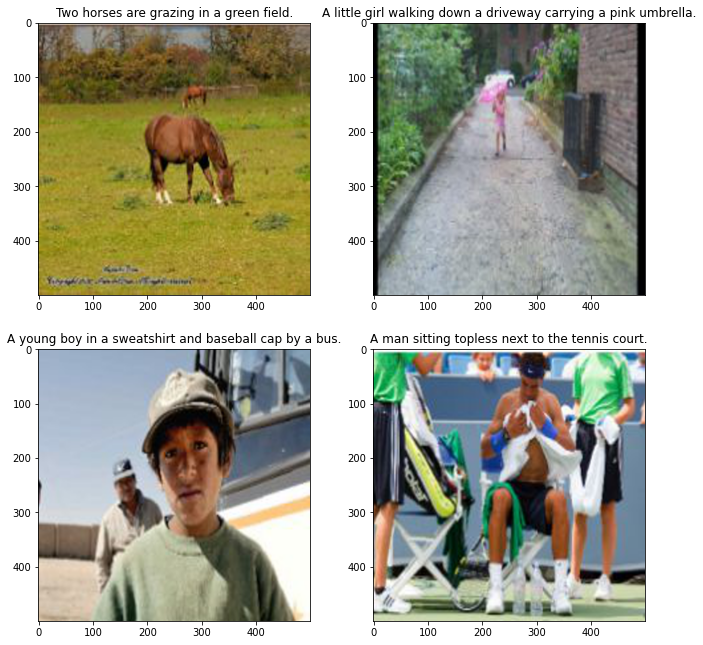

In [51]:
from PIL import Image
import json
from os import listdir
import numpy as np
import cv2
import torch
from torch import nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


imgNames = ["./datas/imgs/" + n for n in listdir("./datas/imgs/")]
titlesNames = ["./datas/titles/" + n for n in listdir("./datas/titles/")]#资源文件名列表

imgs = [np.array(Image.open(iN).resize((500, 500))) for iN in imgNames]
titles = [json.load(open(tN))["GT"] for tN in titlesNames]#读入资源

fig1, ax1 = plt.subplots(2, 2, figsize=(11, 11))

for i in range(2):
    for j in range(2):
        print("img size:", imgs[i * 2 + j].shape)
        ax1[i][j].imshow(imgs[i * 2 + j])
        ax1[i][j].set_title(titles[i * 2 + j])

# 前处理与后处理中转换pre&post processing
* 图像就是大小resize一下，然后从HWC[0,255]转换为CHW[0,1]
* 句子嵌入为词向量组，使用的是torchtext中基于fasttext的预训练词嵌入模型(而且由于数据集过小，仅demo做测试用，所以不建立词库并one-hot编码，不根据词库中有的词选取词向量组成嵌入矩阵$W_{embedding}$, 当然正常的NLP工程要么这么做，要么直接对自己的数据集训练特定的$W_{embedding}$, 而且这么做效率会很低下), 需要清洗掉停用词和标点，规则较为简单
* 因此，对于输出的结果，不会再采用论文中的基于对数据集建立特定词库的概率搜索贪心 or beamsearch进行解码，会直接基于预训练模型的算cosine similarity用topk的近义词搜索，即decoder每个生成的词依旧是词向量的shape

### 定义预训练词向量、图像格式转换、停用词表

In [4]:
from torchvision import transforms
from torchtext import vocab

fastText = vocab.FastText()# fastText 预训练模型

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])#图像转换

with open("./datas/stopwords.txt") as f:#停用词表
    s = f.read()
    s = s.split("\n")
    f.close()

### fastText 词嵌入矩阵的大小

In [5]:
print(fastText.vectors.shape)

torch.Size([2519370, 300])


### 清洗句子

In [6]:
def wash(sentence):
    sentence = "".join(filter(lambda x: x.isalnum() or x == " ", list(sentence)))#洗去标点
    words = [i for i in sentence.split(" ") if i not in s]#洗去停用词
    return words

print("before:", titles[0])#展示
print("after:", wash(titles[0]))

before: Two horses are grazing in a green field.
after: ['Two', 'horses', 'grazing', 'green', 'field']


### 句子变为词向量组

In [7]:
def sts2vecs(sentence):
    words = wash(sentence)
    vecs = torch.stack([fastText.get_vecs_by_tokens(word) for word in words])
    return vecs

sts2vecs(titles[0]).shape#展示维度

torch.Size([5, 300])

### 搜索近义词， 当cosine similiarity小于一定阈值时，全部替换为\<unk\>

In [8]:
def getSimilarWord(wordvec, k):
    W = fastText.vectors
    x = wordvec

    cos = torch.matmul(W, x.view((-1,))) / (
            (torch.sum(W * W, dim=1)).sqrt() * torch.sum(x * x).sqrt()) #计算cosine相似度

    _, topks = torch.topk(cos, k=k)
    cosines = [cos[i] for i in topks if cos[i].item() > 0.1]
    words = [fastText.itos[i] for i in topks if cos[i].item()> 0.1]
    while len(words) < 5:#OOV 情况用<unk>填充
        cosines.append(torch.tensor(0, dtype=torch.float32))
        words.append("<unk>")

    return words, cosines

getSimilarWord(fastText.get_vecs_by_tokens("chips"), 5)#展示与chips最相近的词向量

(['chips', 'chip', 'microchips', 'chipsy', 'pcchips'],
 [tensor(1.0000),
  tensor(0.8048),
  tensor(0.6800),
  tensor(0.6770),
  tensor(0.6579)])

### 实现dataset

In [9]:
from torch.utils.data import DataLoader, Dataset

class imgcapDataset(Dataset):
    def __init__(self):
        super().__init__()
        self.imgNames = ["./datas/imgs/" + n for n in listdir("./datas/imgs/")]
        self.titlesNames = ["./datas/titles/" + n for n in listdir("./datas/titles/")]

    def __getitem__(self, index):
        return trans(Image.open(self.imgNames[index])),\
            sts2vecs(json.load(open(self.titlesNames[index]))["GT"])

    def __len__(self):
        return len(self.imgNames)

icap = imgcapDataset()
print("正确的图像shape(unbatched):", icap[0][0].shape, "\n正确的词向量shape(unbatched):",icap[0][1].shape)#测试

正确的图像shape(unbatched): torch.Size([3, 224, 224]) 
正确的词向量shape(unbatched): torch.Size([5, 300])


# NIC的复现
### 模型部分
![image-20220629084141451](indoor.assets/image-20220629084141451.png)
### 推理时刻则是循环则是用上一个时间步的输出做下一个时间步的输入, 第一个时间步的输出由输入的图片产生，即文献中的$x_{-1}$, 但是只做定长推理，这里为10的长度


In [10]:
import torch
from torchvision.models import resnet18
from torch import nn

class NIC(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = resnet18(pretrained=True) # resnet18做解码器，提取特征
        self.l1 = nn.Linear(1000, 300) # 将resnet18的1000维提取结果做投影，投影为LSTM单元的输入300维
        self.decoder = nn.LSTM(input_size=300, hidden_size=300, batch_first=True)#LSTM做编码器生成对应

    def forward(self, img, sentence):#训练模式
        x0 = self.l1(torch.stack([self.encoder(img)]))
        X = torch.concat((x0, sentence), dim=1)# 拼接img与sentence
        y = self.decoder(X)
        return y[0]

    def infer(self, img):#推理模式, 非batch
        vecsBefore = self.l1(self.encoder(img.unsqueeze(0)))

        for i in range(10):#得到10个时间步内的生成的结果
            newInfer = self.decoder(vecsBefore)[0][-1:]#将最新的推理结果变为下一步的输入
            vecsBefore = torch.concat((vecsBefore, newInfer))

        words = [getSimilarWord(vec, 1)[0][0] for vec in vecsBefore[1:]]
        string = " ".join(words)#将词向量组变程单词集合然后变为句子
        string += "."

        return string

test2 = NIC()#测试
print("训练时正确的输出shape:\n", test2(icap[0][0].unsqueeze(0), icap[0][1].unsqueeze(0)).shape)
print("推理时产生的句子(未训练):\n", test2.infer(icap[0][0]))

训练时正确的输出shape:
 torch.Size([1, 6, 300])
推理时产生的句子(未训练):
 thzy taskforcename apokjeden apokjeden apokjeden trups trups trups trups trups.


# 训练
* 这里不再使用最小化对数概率做损失进行预测，而是将生成词向量与ground truth词向量的cosine similarity进行最大化，并且用惩罚放大每次生成的词汇中和原词向量相差较大部分
* 该损失函数为自定义的平均指数错误损失$Loss({v_{1},v_{2},...v_{n}}) = -\frac{1}{n}\sum_{i=1}^{n}\theta^{||v_{i}-gt_{i}||}, v_{i}为生成的词向量, gt_{i}为真值, \theta 为超参$
* 选取多步下降的学习率调整策略, adam优化器

### 自定义损失函数

In [11]:
from torch import nn

class expAvgError(nn.Module):
    def __init__(self, theta):
        super().__init__()
        self.theta = theta#超参

    def forward(self, vecBatchs, gtBatchs):#注意自己实现时的batch
        sum = torch.tensor(0, dtype=torch.float32, requires_grad=True)

        for vecs, gts in zip(vecBatchs, gtBatchs):
            for vec, gt in zip(vecs, gts):
                sum = sum + torch.pow(torch.tensor(self.theta), torch.norm(vec - gt, p=2)) / vecs.size(0)

        return sum

_loss = expAvgError(2)
print("loss:", _loss(torch.rand(2, 10, 300), torch.rand(2, 10, 300)), _loss(torch.rand(1, 10, 300), torch.rand(1, 10, 300)))#测试, 大概是两倍的关系

loss: tensor(274.1057, grad_fn=<AddBackward0>) tensor(122.2455, grad_fn=<AddBackward0>)


### 学习率与adam调整

epoch:1/30, loss:2.1e+01, lr:0.00100000
epoch:2/30, loss:1.6e+01, lr:0.00100000
epoch:3/30, loss:1.3e+01, lr:0.00100000
epoch:4/30, loss:9.5, lr:0.00050000
epoch:5/30, loss:1e+01, lr:0.00050000
epoch:6/30, loss:1e+01, lr:0.00050000
epoch:7/30, loss:1e+01, lr:0.00025000
epoch:8/30, loss:8.2, lr:0.00025000
epoch:9/30, loss:8.1, lr:0.00012500
epoch:10/30, loss:9.8, lr:0.00012500
epoch:11/30, loss:7.7, lr:0.00012500
epoch:12/30, loss:1e+01, lr:0.00006250
epoch:13/30, loss:7.9, lr:0.00006250
epoch:14/30, loss:9.2, lr:0.00006250
epoch:15/30, loss:7.9, lr:0.00003125
epoch:16/30, loss:9.1, lr:0.00003125
epoch:17/30, loss:7.9, lr:0.00001563
epoch:18/30, loss:7.9, lr:0.00001563
epoch:19/30, loss:7.5, lr:0.00001563
epoch:20/30, loss:9.0, lr:0.00000781
epoch:21/30, loss:7.8, lr:0.00000781
epoch:22/30, loss:7.5, lr:0.00000781
epoch:23/30, loss:7.8, lr:0.00000391
epoch:24/30, loss:7.8, lr:0.00000391
epoch:25/30, loss:8.9, lr:0.00000195
epoch:26/30, loss:8.9, lr:0.00000195
epoch:27/30, loss:7.8, lr:0

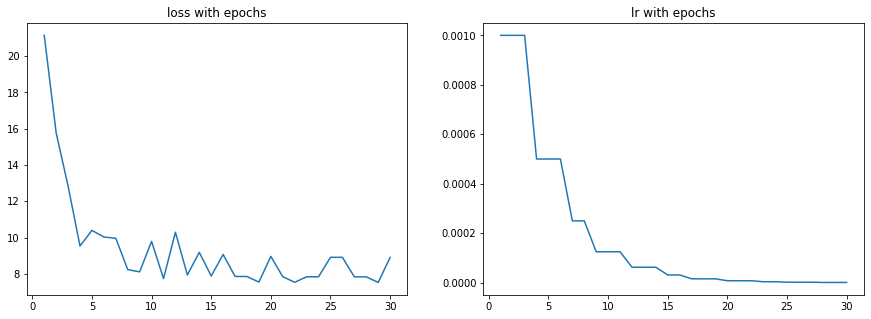

In [14]:
def train(epochs, interval, model, optimizer, dataLoader, criterion, scheduler, savedir):
    LRrates = []
    losses = []
    steps = []
    cnt = 0
    lastMinL = 0

    for epoch in range(epochs):
        for idx, (img, gts) in enumerate(dataLoader):
            if idx % 4 != 0:# 训练部分
                predicts = model(img, gts)
                loss = criterion(predicts, gts)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

            else: #评估部分
                model.eval()
                predicts = model(img, gts)
                loss = criterion(predicts, gts)
                lr = scheduler.get_last_lr()[0]

                cnt += 1
                if (len(losses) > 0):
                    lastMinL = min(losses)

                losses.append(loss.item())
                LRrates.append(lr)
                steps.append(cnt)
                print("epoch:{}/{}, loss:{:.2}, lr:{:.8f}".format(epoch + 1, epochs, loss, lr))#展示，打印与可视化

                if lastMinL > loss.item(): #如果是当前最小，则保存权重
                    torch.save(model.state_dict(), "./{}/epoch-{}.pth".format(savedir, epoch))

    fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))
    ax2[0].plot(steps, losses)
    ax2[0].set_title("loss with epochs")
    ax2[1].plot(steps, LRrates)
    ax2[1].set_title("lr with epochs")
    plt.show()


myNIC = NIC()
criterion1 = expAvgError(theta=2)
optimizer1 = torch.optim.Adam(myNIC.parameters(), lr=0.001)
scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer1, milestones=[8 * i for i in range(1, 100)], gamma=0.5)# 多步学习率下降，以step为界, 每次学习率折半
icapLoader = DataLoader(icap, batch_size=1, shuffle=True, num_workers=0)

train(30, 2, myNIC, optimizer1, icapLoader, criterion1, scheduler1, "best")

### 评估, torchtext中的BLEU score
* 虽然是数据集仅有4张图片句子对的demo，但是可以看见记住了一些词汇

In [15]:
from torchtext.data.metrics import bleu_score

predict = myNIC.infer(icap[3][0])
gt = titles[3]

In [16]:
print("predict:")
print(predict)
print("\nGround Truth:")
print(gt)
print("\nBLEU-4 score:", bleu_score([predict.split(" ")], [gt.split(" ")], max_n=4))

predict:
boy shirtless shirtless tennis tennis tennis tennis tennis tennis tennis.

Ground Truth:
A man sitting topless next to the tennis court.

BLEU-4 score: 0.0


# Attention的复现
* 分别实现:
    * 接受打分函数: 加性（有可学习参数）、点积（最常用）、缩放点积、双线性模型（有可学习参数）
    * multihead
    * key-value的attention
    * self-attention
    * 可选输入输出是否带可学习的线性层
    * batched

In [17]:
class Attention(nn.Module):
    def __init__(self, input_size, s='dot', head=1, haveMLP=True):#根据模式选择
        super().__init__()
        self.s = s
        self.haveMLP = haveMLP
        self.head = head
        self.input_size = input_size
        self.softmax = nn.Softmax(dim=1)
        # 打分函数中的可学习参数
        if s == "bilinear": # 双线性模型
            self.fWbi = nn.Linear(input_size, input_size)
        if s == "add": # 加性模型
            self.fUadd = nn.Linear(input_size, input_size)
            self.fWadd = nn.Linear(input_size, input_size)
            self.fVadd = nn.Linear(input_size, 1)

        if haveMLP:
            self.Wq = nn.Linear(input_size, input_size)
            self.Wv = nn.Linear(input_size, input_size)
            self.Wk = nn.Linear(input_size, input_size)
            self.Wout = nn.Linear(input_size, input_size * head)# 这里采取的是拼接多头输出的办法

    def forward(self, v, q=None, k=None):# 注意，q、v、k要二维，即一组复数特征维
        attscore = None
        out = None

        if q == None: # 如果没有查询向量，q、k、v相同
            q = v
        if k == None: # 如果不是key-value, key就是value
            k = v

        if self.haveMLP:
            v = self.Wv(v)
            q = self.Wq(q)
            k = self.Wk(k)

        if q.dim() < 3:
            q = q.t()
        else:
            q = q.transpose(1, 2)# 查询为矩阵的情况

        if self.s == 'dot':#点积
            attscore = torch.matmul(k, q)
        elif self.s == 'dotscale':#缩放点积
            attscore = torch.matmul(k, q) / torch.sqrt(torch.tensor([len(v)], dtype=torch.float32))
        elif self.s == 'bilinear':
            attscore = torch.matmul(self.fWbi(k), q)
        else:
            attscore = self.fVadd(torch.tanh(self.fWadd(k) + self.fUadd(q)))


        attscore = self.softmax(attscore)#得到注意力

        if q.dim() < 3:# 当查询为向量时，按元素乘
            out = attscore * v
        else:# 用矩阵乘法进行注意力操作，当查询为矩阵时
            out = torch.matmul(attscore, v)

        if self.haveMLP:# 有MLP参数则直接经过线性层，否则拼接
            out = self.Wout(out)
        else:
            out = torch.concat([out for i in range(self.head)], dim=1)

        return out

### 最简单的attention

In [18]:
mostNormalone = Attention(100, haveMLP=False)
mostNormalone(torch.rand(1, 10, 100), torch.rand(1, 100)).shape

torch.Size([1, 10, 100])

### key-valued&scaled attention

In [19]:
TransFATT = Attention(100, haveMLP=True, head=8, s='dotscale')
TransFATT(v=torch.rand(1, 10, 100), q=torch.rand(1, 100), k=torch.rand(1, 10, 100)).shape

torch.Size([1, 10, 800])

### self attention

In [20]:
selfATT = Attention(100, haveMLP=True, head=8)
selfATT(torch.rand(1, 10, 100)).shape

torch.Size([1, 10, 800])

# NIC with Attention, <<show, attent&tell>>中的架构
* 论文中lstm单元的任何门（x表示门下标如i表示输入门、f表遗忘门）的公式输入形如$W_xEy_{t-1} + U_xh_{t-1} + Z_xz_t + b_x$, 但由于我们没有特定实现该lstm单元，所以实际上实现的是$W_x(Ey_{t-1} + Z_xz_t)+ U_xh_{t-1} + b_x$, 这在矩阵乘法的意义上是等价的，但从链式意义上的通过反向传播的优化来说并不等价W会学到z的分布有关的权重，但这样的实现则认为图像的中间表示与句子的中间表示是一个整体
* 增加上面实现的attention
* 做attention的h0就是一开始图片中间表示，c0则用attention过的中间表示初始化
* 除模型架构外，剩下均采用NIC的方法

In [21]:
from torchvision.models import vgg11

class AttNIC(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = vgg11(pretrained=True)
        self.l1 = nn.Linear(1000, 300)
        self.attention = Attention(300, haveMLP=True, head=1)
        self.decoder = nn.LSTM(input_size=300, hidden_size=300, batch_first=True)

    def forward(self, img, sentence):#训练模式
        a = self.l1(torch.stack([self.encoder(img)]))
        z = None # 初始attention
        hBefore = a # 初始隐状态
        out = torch.zeros(sentence.shape)

        for i in range(len(sentence)):
            z = self.attention(a, hBefore)# 用隐状态做查询

            for j in range(i):
                sentence[j] = sentence[j] + z #每个词加上attention后的图片向量

            if i == len(sentence) - 1:
                out = self.decoder(sentence)[0]# 如果遍历到了最后的词，则输出
            else:
                hBefore = self.decoder(sentence[:i + 1])[1][0] # 否则，更新隐状态

        return out

    def infer(self, img):#推理模式, 非batch
        a = self.l1(self.encoder(img.unsqueeze(0)))
        z = None # 初始attention
        hBefore = a # 初始隐状态
        out = None
        newInfer = None
        vecsBefore = None

        for i in range(11):
            z = self.attention(a, hBefore)# 用隐状态做查询

            if vecsBefore == None:# 第一个输入c0用一开始的z初始化
                vecsBefore = z

            for j in range(i):
                vecsBefore[j] = vecsBefore[j] + z #每个词加上attention后的图片向量

            if i == 10:
                out = self.decoder(vecsBefore)[0]# 如果遍历到了最后的词，则输出
            else:
                hBefore = self.decoder(vecsBefore[:i + 1])[1][0] # 否则，更新隐状态
                newInfer = self.decoder(vecsBefore)[0][-1:]#将最新的推理结果变为下一步的输入
                vecsBefore = torch.concat((vecsBefore, newInfer))

        words = [getSimilarWord(vec, 1)[0][0] for vec in vecsBefore[1:]]
        string = " ".join(words)#将词向量组变程单词集合然后变为句子
        string += "."

        return string

myAttNIC = AttNIC()#测试
print("训练时正确的输出shape:\n", myAttNIC(icap[0][0].unsqueeze(0), icap[0][1].unsqueeze(0)).shape)
print("推理时产生的句子(未训练):\n", myAttNIC.infer(icap[0][0]))

训练时正确的输出shape:
 torch.Size([1, 5, 300])
推理时产生的句子(未训练):
 미술관 미술관 미술관 미술관 미술관 미술관 미술관 미술관 juergensmeyer cutivate.


# AttNIC的训练
* 可以看到结果非常不稳定， 原因很可能是没有对feature进行位置编码，因为attention学不到关于位置的信息

epoch:1/10, loss:7.7e+02, lr:1000.00000000
epoch:2/10, loss:5.9e+02, lr:1000.00000000
epoch:3/10, loss:7.7e+02, lr:1000.00000000
epoch:4/10, loss:7.7e+02, lr:900.00000000
epoch:5/10, loss:2.7e+02, lr:900.00000000
epoch:6/10, loss:4.1e+02, lr:900.00000000
epoch:7/10, loss:2.7e+02, lr:810.00000000
epoch:8/10, loss:5.9e+02, lr:810.00000000
epoch:9/10, loss:7.7e+02, lr:729.00000000
epoch:10/10, loss:2.7e+02, lr:729.00000000


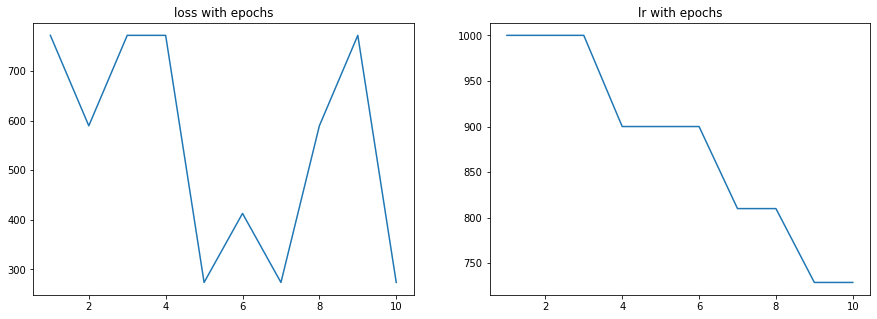

In [35]:
criterion3 = expAvgError(theta=4)
optimizer3 = torch.optim.Adam(myNIC.parameters(), lr=1000)
scheduler3 = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer3, milestones=[8 * i for i in range(1, 100)], gamma=0.9)# 多步学习率下降，以step为界, 每次学习率折半
train(10, 2, myAttNIC, optimizer3, icapLoader, criterion3, scheduler3, "best2")

### AttNIC的评估

In [36]:
from torchtext.data.metrics import bleu_score

predict2 = myAttNIC.infer(icap[3][0])
gt2 = titles[3]
print("predict:")
print(predict2)
print("\nGround Truth:")
print(gt2)
print("\nBLEU-4 score:", bleu_score([predict2.split(" ")], [gt2.split(" ")], max_n=4))

predict:
rivl rivl rivl rivl rivl rivl rivl rivl rivl fs.

Ground Truth:
A man sitting topless next to the tennis court.

BLEU-4 score: 0.0


# nn中Tranformer的实现

In [39]:
myTrans = nn.Transformer()
print(myTrans)# 整体架构

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, in

In [47]:
print(myTrans.encoder.layers[0].self_attn)# 具体的attention结构
print(myTrans.encoder.layers[0].self_attn.out_proj)

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
)
NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)


In [50]:
myTrans(torch.rand(1, 10, 512), torch.rand(1, 10, 512)).shape#类似机器翻译任务

torch.Size([1, 10, 512])